# Imbalance classfication problem

The jupyter notebook includes all related algorithms and results to load dataset, visualize principal conponents, and, prediting the data's label using Logistic regression and a designed neural network.

## Introduction

Imbalanced classfication problem (Rare event prediction, Extreme event prediction, Severe class imbalance) refers to a class distribution that is inherently not balanced. As we will see in the classes distribution that they are not balanced.
 
There are perhaps two main groups of causes for the imbalance we may want to consider; they are data sampling and properties of the domain. Errors may have been made when collecting the observations. One type of error might have been applying the wrong class labels to many examples. Alternately, the processes or systems from which examples were collected may have been damaged or impaired to cause the imbalance.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


NUM_PCA_COMPONENT: int = 2
PCA_VARIANCE: np.float = 0.95
NUM_LDA_COMPONENT: int = 2


def get_data() -> List[pd.DataFrame]:
    input_train_data = pd.read_csv('train_x.csv')
    output_train_data = pd.read_csv('train_y.csv')
    input_test_data = pd.read_csv('test_x.csv')
    return input_train_data, output_train_data, input_test_data


def standardize_data(input_train_data: pd.DataFrame, input_test_data: pd.DataFrame) -> List[np.ndarray]:
    in_train = StandardScaler().fit_transform(input_train_data)
    in_test = StandardScaler().fit_transform(input_test_data)
    return in_train, in_test


def project_data(data: pd.DataFrame) -> pd.DataFrame:
    pca = PCA(n_components=NUM_PCA_COMPONENT)
    principalComponents = pca.fit_transform(data)
    principalDf = pd.DataFrame(data = principalComponents,
                                columns = ['principal component 1', 'principal component 2'])
    return principalDf, pca


def visualize_data_pca(final_df: pd.DataFrame) -> plt.plot:
    fig = plt.figure(figsize = (6,6))
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title('2 component PCA', fontsize = 20)
    targets = [1, 0]
    colors = ['g', 'r']
    for target, color in zip(targets,colors):
        indicesToKeep = final_df['target'] == target
        ax.scatter(final_df.loc[indicesToKeep, 'principal component 1'],
                    final_df.loc[indicesToKeep, 'principal component 2'],
                    c = color,
                    s = 50)
    ax.legend(targets)
    ax.grid()


def visualize_data_lda(input_train_data: pd.DataFrame, out_train_data: pd.DataFrame) -> plt.plot:
    y = out_train_data.target
    X = input_train_data
    y.loc[4001] = y.loc[2] + 2
    X.loc[4001] = input_train_data.loc[0] * 10

    lda = LinearDiscriminantAnalysis(n_components=NUM_LDA_COMPONENT)
    # X_r = lda.fit(X, y).transform(X)
    X_lda = lda.fit_transform(X, y)
    colors = ['navy', 'red']
    target_names = ['False', 'True']
    plt.figure()
    for color, i, target_name in zip(colors, [0, 1], target_names):
        plt.scatter(X_lda[y == i, 0], X_lda[y == i, 1], alpha=.8, color=color,
                    label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('2 LDA of data')
    plt.xlabel('LDA 1')
    plt.ylabel('LDA 2')
    plt.grid()
    plt.show()
    print(f"The LDA variance ratios are {lda.explained_variance_ratio_}")

# Examining the possibility of exisiting imbalance in the dataset

In this step, the train data and test data will be loaded, then, we should examine the number of data in each classes to evaluate the possibility of existing imbalance between classes.

Slight Imbalance. An imbalanced classification problem where the distribution of examples is uneven by a small amount in the training dataset (e.g. 4:6).

Severe Imbalance. An imbalanced classification problem where the distribution of examples is uneven by a large amount in the training dataset (e.g. 1:100 or more).

The minority class is harder to predict because there are few examples of this class, by definition.

In [2]:
input_train_data, out_train_data, input_test_data = get_data()
data = input_train_data.copy()
data['target'] = out_train_data['target']
classes_ratio = (len(data[data['target'] == 1]) / len(data[data['target'] == 0]))
if classes_ratio <= 0.6:
    print("There exists severe imablance!!")
if classes_ratio >= 0.6 and classes_ratio <= 0.95:
    print("There exists slight imbalance!!")

There exists severe imablance!!


# Visualize Principal Components

The dataset should be normalized in order to avoid any problem not only in learning phase but also in computing principal components. Eventually, they data will be shown by considering principal components.

Since PCA yields a feature subspace that maximizes the variance along the axes, it makes sense to standardize the data, especially, if it was measured on different scales. Although, all features in the Iris dataset were measured in centimeters, let us continue with the transformation of the data onto unit scale (mean=0 and variance=1), which is a requirement for the optimal performance of many machine learning algorithms.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data.

Here we plot the different samples on the 2 first principal components.

The pca's variance ratio is [0.18547859 0.07738929]


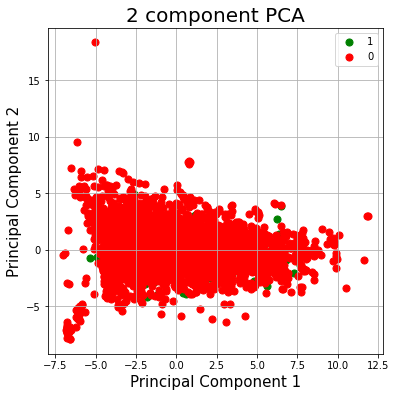

In [3]:
in_train, in_test = standardize_data(input_train_data, input_test_data)
principal_df, pca = project_data(in_train)
final_df = pd.concat([principal_df, out_train_data[['target']]], axis = 1)
visualize_data_pca(final_df)
print(f"The pca's variance ratio is {pca.explained_variance_ratio_}")

The plot of the dataset is created showing the large mass of examples for the majority class (red) and a small number of examples for the minority class (green), with some class overlap.

# Linear Discriminant Analysis (LDA)

LDA tries to identify attributes that account for the most variance between classes. In particular, LDA, in contrast to PCA, is a supervised method, using known class labels.

Teh plot of the dataset is created showing the large mass of examples for the majority class (blue) and a small number of examples for the minority class (red), with some class overlap

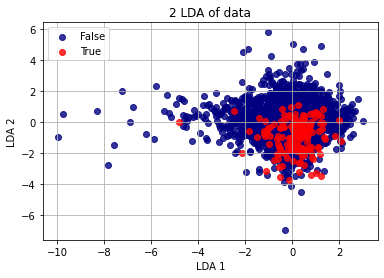

The LDA variance ratios are [0.99853512 0.00146488]


In [4]:
visualize_data_lda(input_train_data, out_train_data)

# Applying PCA to the Data
Principal Component Analysis (PCA) applied to this data identifies the combination of attributes (principal components, or directions in the feature space) that account for the most variance in the data.

In [5]:
pca = PCA(PCA_VARIANCE)
pca.fit(in_train)
print(f"Num of principal components is {pca.n_components_}")
train_ = pca.transform(in_train)
test_ = pca.transform(in_test)

Num of principal components is 35


# Logistic Regression
The fitting problem for train data will be computed by using Logistic Regression in this step. Then, the fitting accuracy will be computed for the seperated test data.

accuracy (fraction of correct predictions): correct predictions / total number of data points

In [6]:
train_1, test_1, train_lbl, test_lbl = train_test_split(train_, out_train_data.target, test_size=1/5.0, random_state=0)
logisticRegr = LogisticRegression(solver = 'lbfgs')
logisticRegr.fit(train_1, train_lbl)
score = logisticRegr.score(test_1, test_lbl)
# print(f"The prediction score is {score}")
print("The prediction score on test: " + str(logisticRegr.score(test_1, test_lbl)))
print("The prediction score on train: "+ str(logisticRegr.score(train_1, train_lbl)))

The prediction score on test: 0.95
The prediction score on train: 0.9621875


# Predicted data

The target for the test data will be calculated using the obtained parameters in LogisticRegression. Then, the result is saved as a CSV file.

In [7]:
predicted_test = logisticRegr.predict(test_)
test_y = pd.DataFrame(predicted_test, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 

,Unnamed: 0,target
0,3915,0.0
1,4339,0.0
2,3422,0.0
3,5624,0.0
4,886,0.0
5,5936,0.0
6,3179,0.0
7,3969,0.0


## NOTES on Logisitic Regression:

1) The difference betweeen train score and test score is not significant, then, there does not exist any overfitting in the logistic regression fitting.

2) As the results of prediction clarify, all of the predicted targets are zero, which indicate that the logistic regression is not able to solve the imbalance classification problem, and causes the following problem. 

The abundance of samples from the majority class can swamp the minority class. Most machine learning algorithms for classification predictive models are designed and demonstrated on problems that assume an equal distribution of classes. This means that a naive application of a model may focus on learning the characteristics of the abundant observations only, neglecting the examples from the minority class that is, in fact, of more interest and whose predictions are more valuable.

The learning process of most classification algorithms is often biased toward the majority class examples, so that minority ones are not well modeled into the final system.

Eventually, we are going to use deep learning methods to solve the problem.

# Neural Network (Deep Learning)

Deep learning uses an artificial neural network that uses multiple layers to progressively extract higher level features from the training data. We are using a simple three-layer network without any optimisation, except the usage of a small validation dataset. 



# Regularisation

In the following, I applied the 3 best practices for handling overfitting in a neural network:

1) reduce the network’s size

2) adding some weight regularisation

3) adding dropout

## Metrics

There are many metrics for evaluating how good a binary classifier is doing in predicting the class labels for instances/examples. Below are some caveats and suggestions for choosing and interpreting the appropriate metrics.

* Accuracy can be misleading. Since accuracy is simple the ratio of correctly predicted instances over all instances used for evaluation, it is possible to get a decent accuracy while having mostly incorrect predictions for the minority class.

* Confusion matrix helps break down the predictive performances on different classes.

Therefore, we utilize a combination of confusion matrix metrics and specifity-sensivity for solving the problem. Beside, we can compute the classes' weight, then use these weights for fitting problem in order to decrease imbalancing.

In [8]:
from keras import layers, models, optimizers, losses, metrics, regularizers


NUM_VALIDATION: int = int(len(train_) * 0.2)

train_1, test_1, train_lbl, test_lbl = train_test_split(train_, out_train_data.target, test_size=1/5.0, random_state=0)
x_validation = train_1[:NUM_VALIDATION]
x_partial_train = train_1[NUM_VALIDATION:]
y_validation = train_lbl[:NUM_VALIDATION]
y_partial_train = train_lbl[NUM_VALIDATION:]

weight_for_0: np.float = 1.0 / len(out_train_data[out_train_data['target'] ==0])
weight_for_1: np.float = 1.0 / len(out_train_data[out_train_data['target'] ==1])
class_weights = {0: weight_for_0, 1: weight_for_1}

metrics_ = [
    metrics.FalseNegatives(name="fn"),
    metrics.FalsePositives(name="fp"),
    metrics.TrueNegatives(name="tn"),
    metrics.TruePositives(name="tp"),
    metrics.Precision(name="precision"),
    metrics.Recall(name="recall"),
    metrics.SpecificityAtSensitivity(0.05, num_thresholds=40, name=None, dtype=None)
]


def dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(64, activation="relu", input_shape=(train_1.shape[-1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=metrics_[6])
    return model


def regularized_dl_model() -> models.Model:
    model = models.Sequential()
    model.add(layers.Dense(16, activation="relu", input_shape=(train_1.shape[-1],)))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.003), activation='relu'))
    model.add(layers.Dropout(0.6))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=metrics_[6])
    return model

In [10]:
model = dl_model()
model.fit(x_partial_train, y_partial_train,
        epochs=1000,
        batch_size=32,
        verbose=2,
        validation_data=(x_validation, y_validation))

print(140 * '=')
print("score on test: " + str(model.evaluate(test_1, test_lbl)[1]))
print("score on train: "+ str(model.evaluate(train_1, train_lbl)[1]))

0s - loss: 5.3377e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7388 - val_specificity_at_sensitivity: 0.9843
Epoch 864/1000
75/75 - 0s - loss: 5.5647e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7392 - val_specificity_at_sensitivity: 0.9843
Epoch 865/1000
75/75 - 0s - loss: 5.8149e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7392 - val_specificity_at_sensitivity: 0.9843
Epoch 866/1000
75/75 - 0s - loss: 5.5256e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7395 - val_specificity_at_sensitivity: 0.9843
Epoch 867/1000
75/75 - 0s - loss: 5.7841e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7399 - val_specificity_at_sensitivity: 0.9843
Epoch 868/1000
75/75 - 0s - loss: 5.9531e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7422 - val_specificity_at_sensitivity: 0.9843
Epoch 869/1000
75/75 - 0s - loss: 4.9771e-10 - specificity_at_sensitivity: 1.0000 - val_loss: 1.7407 - val_specificity_at_sensitivity: 0.9843
Epoch 870/1000
75/75 - 0s - l

In [12]:
model_regularized = regularized_dl_model()
model_regularized.fit(x_partial_train, y_partial_train,
        epochs=1000,
        batch_size=32,
        verbose=2,
        validation_data=(x_validation, y_validation))

print(140 * '+')
print("score on test: " + str(model_regularized.evaluate(test_1, test_lbl)[1]))
print("score on train: "+ str(model_regularized.evaluate(train_1, train_lbl)[1]))

0s - loss: 0.0442 - specificity_at_sensitivity: 0.9866 - val_loss: 2.0467 - val_specificity_at_sensitivity: 0.9856
Epoch 860/1000
75/75 - 0s - loss: 0.0430 - specificity_at_sensitivity: 0.9862 - val_loss: 2.1558 - val_specificity_at_sensitivity: 0.9830
Epoch 861/1000
75/75 - 0s - loss: 0.0442 - specificity_at_sensitivity: 0.9862 - val_loss: 2.0010 - val_specificity_at_sensitivity: 0.9778
Epoch 862/1000
75/75 - 0s - loss: 0.0394 - specificity_at_sensitivity: 0.9862 - val_loss: 2.2026 - val_specificity_at_sensitivity: 0.9830
Epoch 863/1000
75/75 - 0s - loss: 0.0374 - specificity_at_sensitivity: 0.9875 - val_loss: 2.2307 - val_specificity_at_sensitivity: 0.9869
Epoch 864/1000
75/75 - 0s - loss: 0.0409 - specificity_at_sensitivity: 0.9840 - val_loss: 2.1638 - val_specificity_at_sensitivity: 0.9830
Epoch 865/1000
75/75 - 0s - loss: 0.0410 - specificity_at_sensitivity: 0.9844 - val_loss: 2.1620 - val_specificity_at_sensitivity: 0.9817
Epoch 866/1000
75/75 - 0s - loss: 0.0399 - specificity_at

In [13]:
print("Summary of Deep Learning Model\n")
model.summary()
print(65 * '+')
print("Summary of regularized Deep Learning Model\n")
model_regularized.summary()

Summary of Deep Learning Model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                2304      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 10,689
Trainable params: 10,689
Non-trainable params: 0
_________________________________________________________________
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Summary of regularized Deep Learning Model

Model: "sequential_3"
_________________________________________________________________
Layer (type)      

In [15]:
predictions = model.predict_classes(test_)
test_y = pd.DataFrame(predictions, columns=['target'])
test_y['Unnamed: 0'] = out_train_data['Unnamed: 0']
test_y = test_y[['Unnamed: 0', 'target']]
test_y.to_csv('test_y.csv')
test_y.head(8) 

/home/salar/Documents/Projects/Advanced-Deep-Learning/adl/lib/python3.8/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


,Unnamed: 0,target
0,3915,0
1,4339,0
2,3422,0
3,5624,0
4,886,0
5,5936,0
6,3179,0
7,3969,0


## Notes on Neural Nework's result

* As the test score of the first model is higher than the regularized model, we use this model to predict targets of the test dataset.

* The regularized model has much less train/total parameter, then it's architecture has benefits rather than the firs one.

* According to the result, using the mentioned metrics cause to overcome to imbalance problem.